## A "barren plateau" is a phenomenon in quantum machine learning where the optimization process becomes extremely difficult and slow as the size of the quantum model increases. This happens because the optimization landscape becomes very flat, making it difficult for the optimization process to find the optimal solution.This means that a variational circuit initialized in one of these areas will be untrainable using any gradient-based algorithm. This is due to the large number of parameters in quantum models and the highly entangled nature of quantum systems.

## The effect of barren plateaus on quantum machine learning tasks is that it makes the training process much slower and less efficient, as the optimization process has a difficult time finding the optimal solution.

### Solution : Using Local Cost Functions---By breaking down the large optimization problem into smaller, simpler subproblems, local cost functions make the optimization process more efficient and reduce the risk of getting stuck in the "barren plateau" region.A local cost function only considers information from a few qubits, and attempts to analyze the behavior of the entire circuit from this limited scope.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter

np.random.seed(42)

In [2]:
wires = 6
dev = qml.device("default.qubit", wires=wires, shots=10000)

The global cost function, CG, measures the similarity of the entire quantum state to the desired state, while the local cost function, CL, measures the similarity of each individual qubit's state to the desired state, and sums up the results.

By using a local cost function, the optimization problem becomes simpler and easier to solve, as the optimization can be performed on each qubit individually, rather than the entire quantum state at once. Additionally, using a local cost function can allow for greater control and flexibility in the optimization process, as each qubit can be optimized separately with different methods or parameters.

In this case, the cost functions are defined as 1 - p|0⟩ and 1 - ∑jp|0⟩j, where p|0⟩ is the probability of measuring the state 0. Minimizing the cost function is equivalent to maximizing the probability of measuring the desired state.

In [3]:
def global_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    return qml.probs(wires=range(wires))

def local_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    return [qml.probs(wires=i) for i in range(wires)]

global_circuit = qml.QNode(global_cost_simple, dev)

local_circuit = qml.QNode(local_cost_simple, dev)

def cost_local(rotations):
    return 1 - np.sum(local_circuit(rotations)[:,0])/wires


def cost_global(rotations):
    return 1 - global_circuit(rotations)[0]

In [4]:
RX = np.random.uniform(low=-np.pi, high=np.pi)
RY = np.random.uniform(low=-np.pi, high=np.pi)
rotations = [[RX for i in range(wires)], [RY for i in range(wires)]]

### Result

Global Cost:  0.9999000
Local Cost:  0.8373000


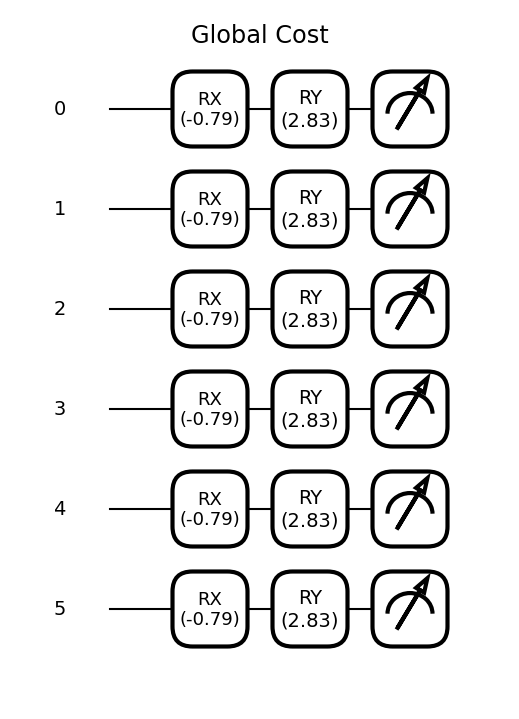

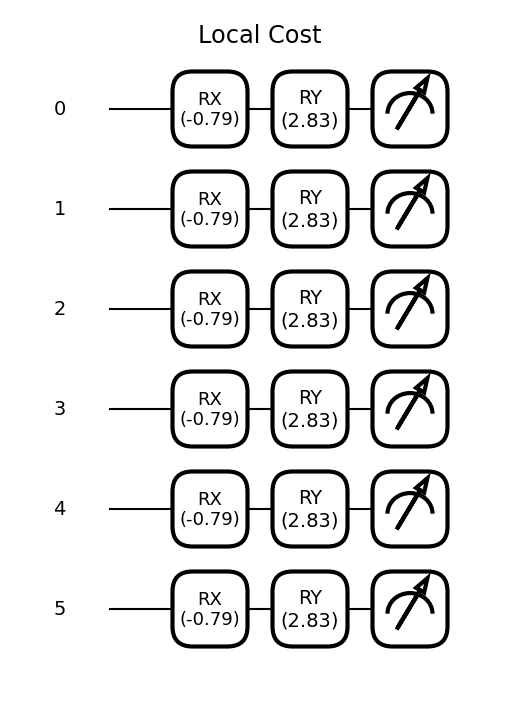

In [5]:
print("Global Cost: {: .7f}".format(cost_global(rotations)))
print("Local Cost: {: .7f}".format(cost_local(rotations)))

qml.drawer.use_style('black_white')
fig1, ax1 = qml.draw_mpl(global_circuit, decimals=2)(rotations)
fig1.suptitle("Global Cost", fontsize='xx-large')
plt.show()

fig2, ax2 = qml.draw_mpl(local_circuit, decimals=2)(rotations)
fig2.suptitle("Local Cost", fontsize='xx-large')
plt.show()

In [6]:
def generate_surface(cost_function):
    Z = []
    Z_assembler = []

    X = np.arange(-np.pi, np.pi, 0.25)
    Y = np.arange(-np.pi, np.pi, 0.25)
    X, Y = np.meshgrid(X, Y)

    for x in X[0, :]:
        for y in Y[:, 0]:
            rotations = [[x for i in range(wires)], [y for i in range(wires)]]
            Z_assembler.append(cost_function(rotations))
        Z.append(Z_assembler)
        Z_assembler = []

    Z = np.asarray(Z)
    return Z

### LinearLocator:Space ticks evenly from min to max.
### FormatStrFormatter:Use an old-style sprintf format string.

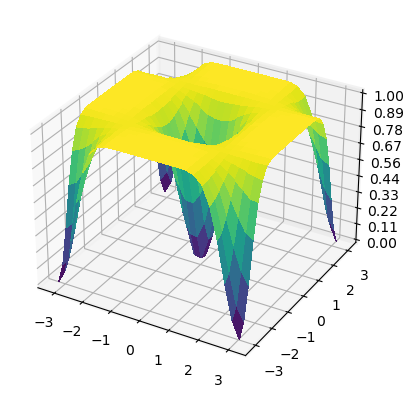

In [7]:
def plot_surface(surface):
    X = np.arange(-np.pi, np.pi, 0.25)
    Y = np.arange(-np.pi, np.pi, 0.25)
    X, Y = np.meshgrid(X, Y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X, Y, surface, cmap="viridis", linewidth=0, antialiased=False)
    ax.set_zlim(0, 1)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
    plt.show()


global_surface = generate_surface(cost_global)
plot_surface(global_surface)

Note : The plot shows a 3D surface representation of the input cost function. The x and y axes represent the parameters of the cost function and range from -π to π with a step size of 0.25. The z axis represents the value of the cost function for each set of parameters and ranges from 0 to 1. The surface is plotted using the "viridis" colormap, which maps the value of the cost function to a color. The color of the surface at each point represents the value of the cost function for that set of parameters. The z axis tick marks and labels are evenly spaced and formatted as floating-point numbers with two decimal places.

The plot provides a visual representation of the input cost function and can be used to understand the shape of the function and the relationships between its parameters and output.

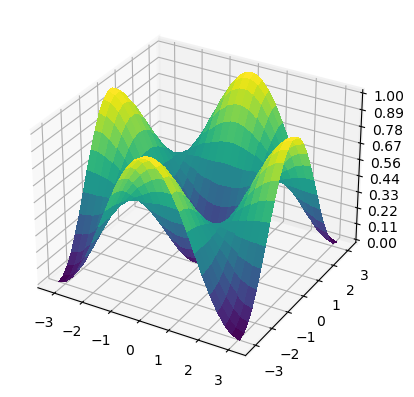

In [8]:
local_surface = generate_surface(cost_local)
plot_surface(local_surface)

To simplify this model, let’s modify our cost function from

CL=1−∑p|0⟩,

where we sum the marginal probabilities of each qubit, to CL=1−p|0⟩,

where we only consider the probability of a single qubit to be in the 0 state.

While we’re at it, let us make our ansatz a little more like one we would encounter while trying to solve a VQE problem, and add entanglement.

In [9]:
def global_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    qml.broadcast(qml.CNOT, wires=range(wires), pattern="chain")
    return qml.probs(wires=range(wires))
def local_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    qml.broadcast(qml.CNOT, wires=range(wires), pattern="chain")
    return qml.probs(wires=[0])



In [10]:
global_circuit = qml.QNode(global_cost_simple, dev)

local_circuit = qml.QNode(local_cost_simple, dev)


In [11]:
def cost_local(rotations):
    return 1 - local_circuit(rotations)[0]
def cost_global(rotations):
    return 1 - global_circuit(rotations)[0]

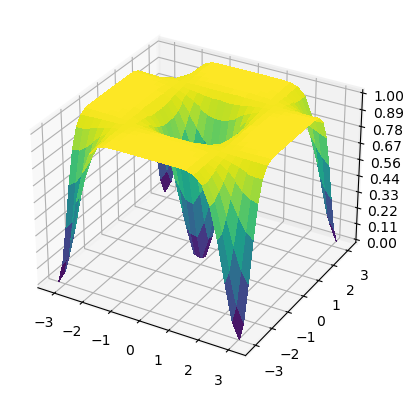

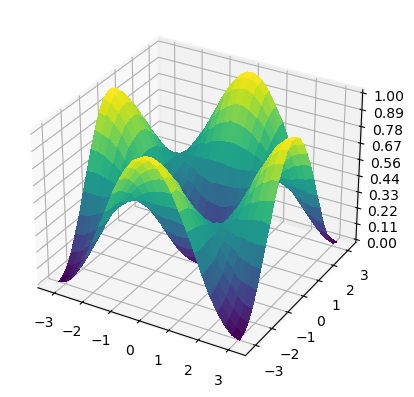

In [12]:
global_surface = generate_surface(cost_global)
plot_surface(global_surface)

local_surface = generate_surface(cost_local)
plot_surface(local_surface)

Cost after step     5:  1.0000000
Cost after step    10:  1.0000000
Cost after step    15:  1.0000000
Cost after step    20:  1.0000000
Cost after step    25:  1.0000000
Cost after step    30:  1.0000000
Cost after step    35:  1.0000000
Cost after step    40:  1.0000000
Cost after step    45:  1.0000000
Cost after step    50:  1.0000000
Cost after step    55:  1.0000000
Cost after step    60:  1.0000000
Cost after step    65:  1.0000000
Cost after step    70:  1.0000000
Cost after step    75:  1.0000000
Cost after step    80:  1.0000000
Cost after step    85:  1.0000000
Cost after step    90:  1.0000000
Cost after step    95:  1.0000000
Cost after step   100:  1.0000000


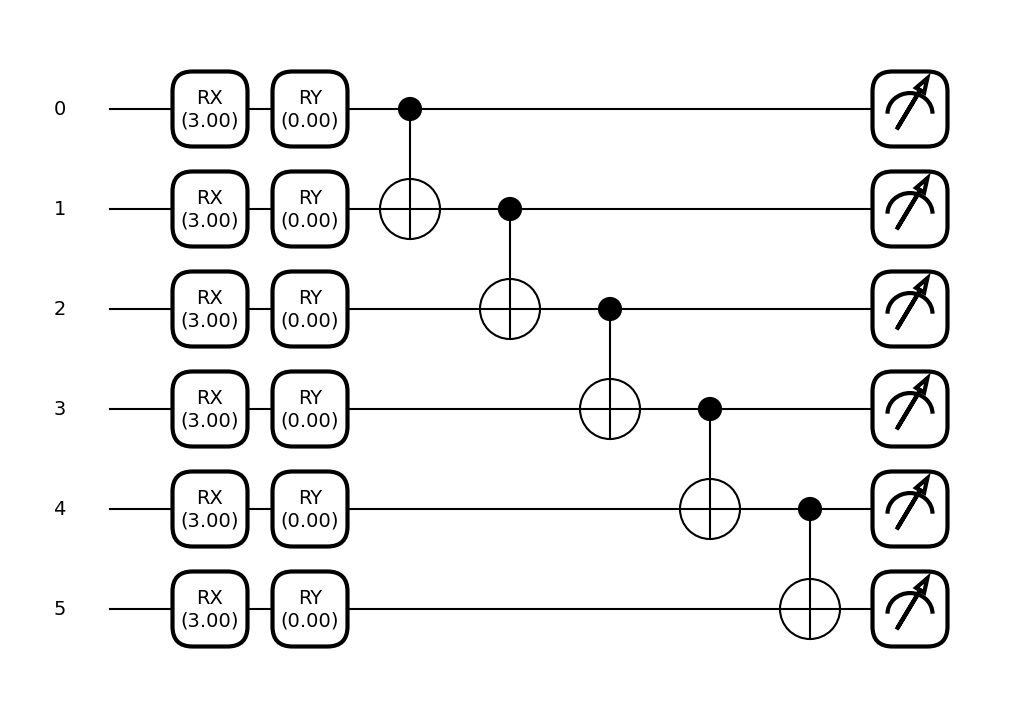

In [13]:
rotations = np.array([[3.] * len(range(wires)), [0.] * len(range(wires))], requires_grad=True)
opt = qml.GradientDescentOptimizer(stepsize=0.2)
steps = 100
params_global = rotations
for i in range(steps):
    # update the circuit parameters
    params_global = opt.step(cost_global, params_global)

    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost_global(params_global)))
    if cost_global(params_global) < 0.1:
        break
fig, ax = qml.draw_mpl(global_circuit, decimals=2)(params_global)
plt.show()

Note:  The cost function represents the error between the target state and the state generated by the quantum circuit. In this case, the cost remains 1.0 at every step, indicating that the optimization process has not been successful in reducing the error and finding the target state

Cost after step     5:  0.9869000
Cost after step    10:  0.9683000
Cost after step    15:  0.9153000
Cost after step    20:  0.8186000
Cost after step    25:  0.6387000
Cost after step    30:  0.3782000
Cost after step    35:  0.1812000
Cost after step    40:  0.0730000
Cost after step    45:  0.0275000
Cost after step    50:  0.0086000


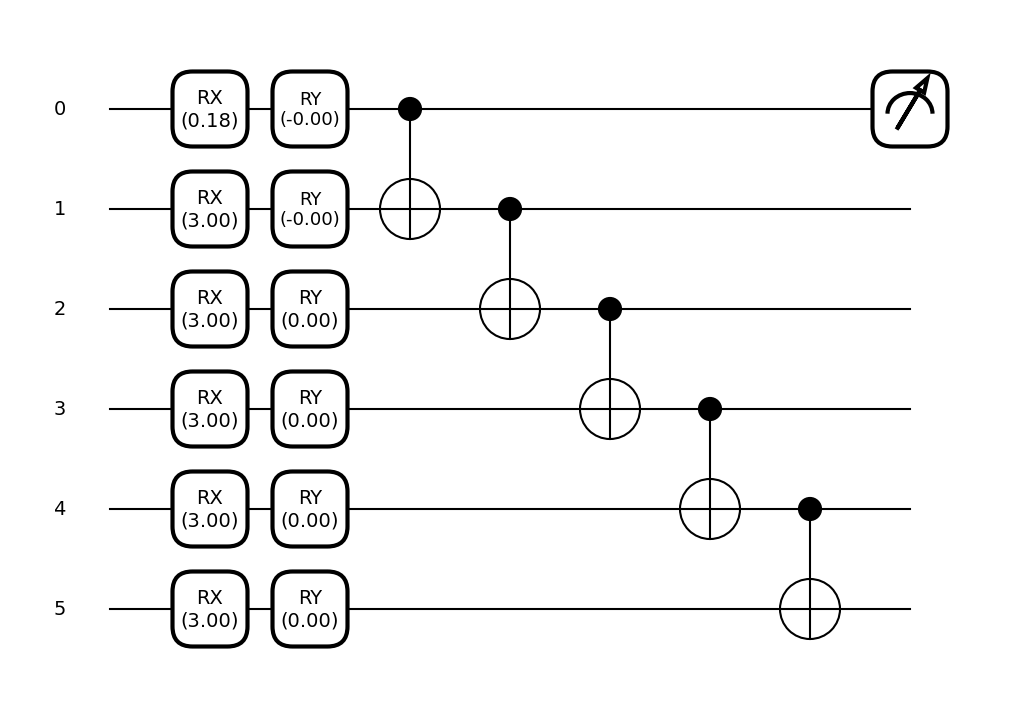

In [16]:
rotations = np.array([[3. for i in range(wires)], [0. for i in range(wires)]], requires_grad=True)
opt = qml.GradientDescentOptimizer(stepsize=0.2)
steps = 100
params_local = rotations
for i in range(steps):
    # update the circuit parameters
    params_local = opt.step(cost_local, params_local)

    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost_local(params_local)))
    if cost_local(params_local) < 0.01:
        break

fig, ax = qml.draw_mpl(local_circuit, decimals=2)(params_local)
plt.show()

In [17]:
cost_global(params_local)

tensor(1., requires_grad=True)

The global cost function is still 1. We have trained the local cost function, the global cost function is unchanged.

As we have trained the global cost a little bit, but not enough to see a change with only 10000 shots. To see the effect, we’ll need to increase the number of shots to an unreasonable amount. 

In [18]:
dev.shots = None
global_circuit = qml.QNode(global_cost_simple, dev)
print(
    "Current cost: "
    + str(cost_global(params_local))
    + ".\nInitial cost: "
    + str(cost_global([[3.0 for i in range(wires)], [0 for i in range(wires)]]))
    + ".\nDifference: "
    + str(
        cost_global([[3.0 for i in range(wires)], [0 for i in range(wires)]])
        - cost_global(params_local)
    )
)

Current cost: 0.9999999999969738.
Initial cost: 0.9999999999999843.
Difference: 3.010591775876037e-12


Training the local cost function alone is not enough to fully train the global circuit and reach the optimal solution. Increasing the locality( locality refers to the number of qubits that the entangling gate will operate on at a given time) gradually as the circuit is trained can help overcome the challenges posed by the plateau region in the cost landscape. This approach is known as layer-wise training and has been found to be effective in deep learning, where each layer is trained one at a time before moving on to the next layer.

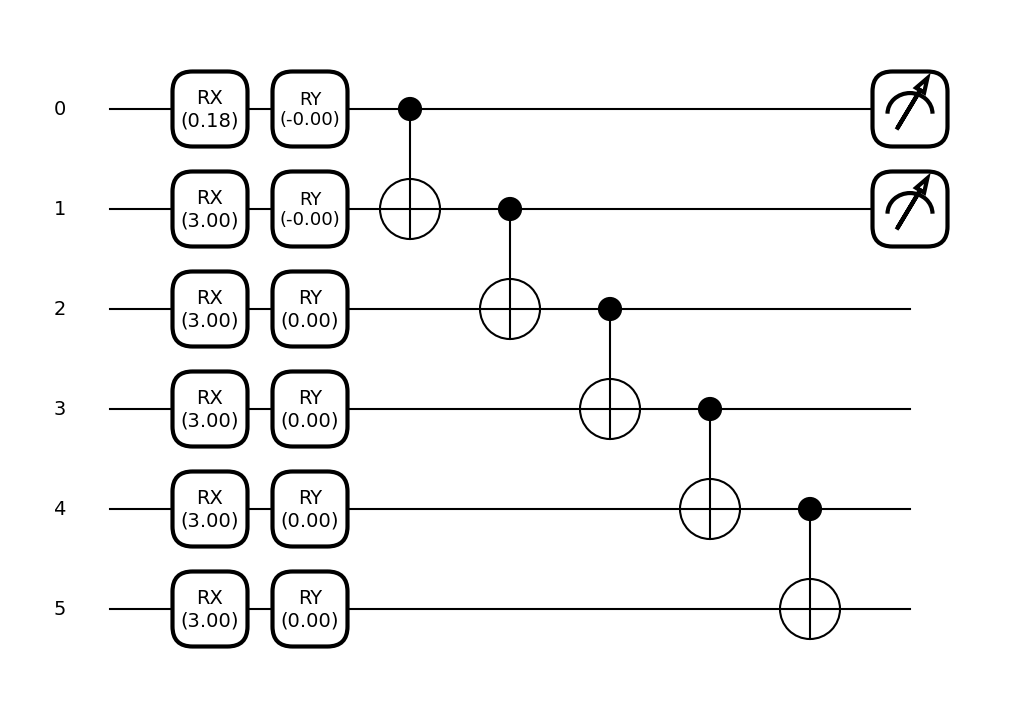

0.9956


In [21]:
def tunable_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    qml.broadcast(qml.CNOT, wires=range(wires), pattern="chain")
    return qml.probs(range(locality))

def cost_tunable(rotations):
    return 1 - tunable_circuit(rotations)[0]

dev.shots = 10000
tunable_circuit = qml.QNode(tunable_cost_simple, dev)
locality = 2
params_tunable = params_local
fig, ax = qml.draw_mpl(tunable_circuit, decimals=2)(params_tunable)
plt.show()
print(cost_tunable(params_tunable))

Cost after step    10:  0.9869000. Locality: 2
Cost after step    20:  0.9652000. Locality: 2
Cost after step    30:  0.9150000. Locality: 2
Cost after step    40:  0.8102000. Locality: 2
Cost after step    50:  0.5978000. Locality: 2
Cost after step    60:  0.3662000. Locality: 2
Cost after step    70:  0.1686000. Locality: 2
---Switching Locality---
Cost after step    80:  0.9951000. Locality: 3
Cost after step    90:  0.9859000. Locality: 3
Cost after step   100:  0.9668000. Locality: 3
Cost after step   110:  0.9231000. Locality: 3
Cost after step   120:  0.8277000. Locality: 3
Cost after step   130:  0.6570000. Locality: 3
Cost after step   140:  0.4196000. Locality: 3
Cost after step   150:  0.2130000. Locality: 3
Cost after step   160:  0.0883000. Locality: 3
---Switching Locality---
Cost after step   170:  0.9887000. Locality: 4
Cost after step   180:  0.9696000. Locality: 4
Cost after step   190:  0.9355000. Locality: 4
Cost after step   200:  0.8508000. Locality: 4
Cost after

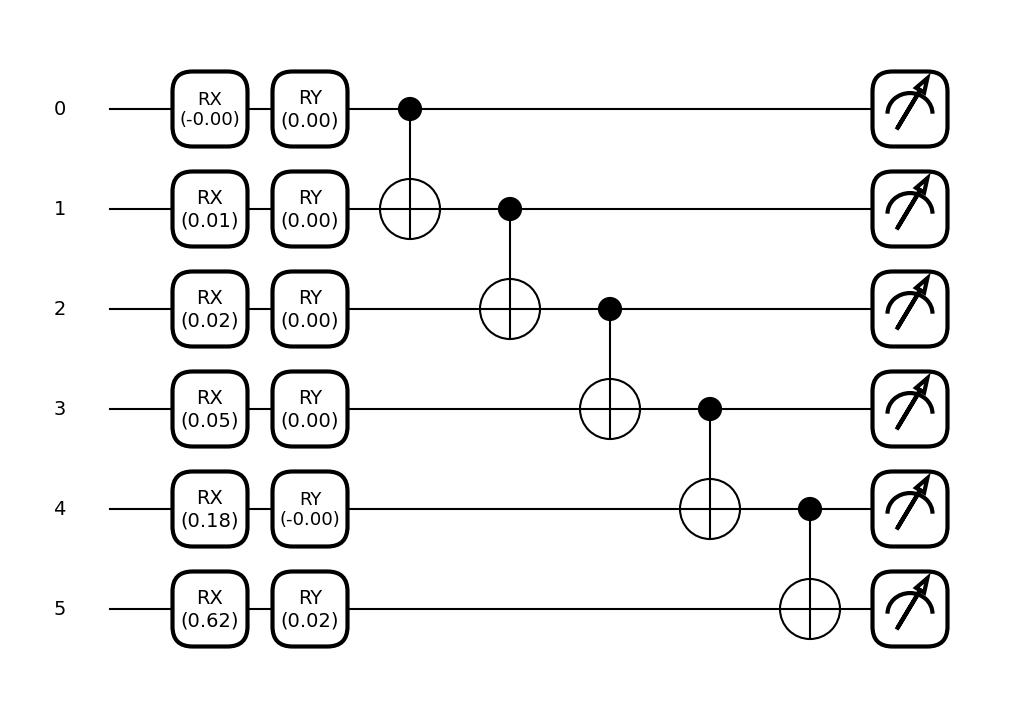

In [22]:
locality = 2
opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 600
for i in range(steps):
    # update the circuit parameters
    params_tunable = opt.step(cost_tunable, params_tunable)

    runCost = cost_tunable(params_tunable)
    if (i + 1) % 10 == 0:
        print(
            "Cost after step {:5d}: {: .7f}".format(i + 1, runCost)
            + ". Locality: "
            + str(locality)
        )

    if runCost < 0.1 and locality < wires:
        print("---Switching Locality---")
        locality += 1
        continue
    elif runCost < 0.1 and locality >= wires:
        break
fig, ax = qml.draw_mpl(tunable_circuit, decimals=2)(params_tunable)
plt.show()